In [1]:
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from specutils import Spectrum1D
import astropy.units as u
import pandas as pd
from scipy.optimize import curve_fit

# this is a pretty fast Dynamic Time Warping implementation, 
# which is pip installable & used in PyKOSMOS
# https://dynamictimewarping.github.io/py-api/html/
import dtw

# current PyKOSMOS working code (will be re-factored to pykosmos)
import sys  
sys.path.append('/Users/james/Dropbox/research_projects/pykosmos/')
from pykosmos.apextract import _gaus
import pykosmos as pk

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':12})
matplotlib.rcParams.update({'font.family':'serif'})

# Cartoon
WTF is DTW?

<IPython.core.display.Javascript object>


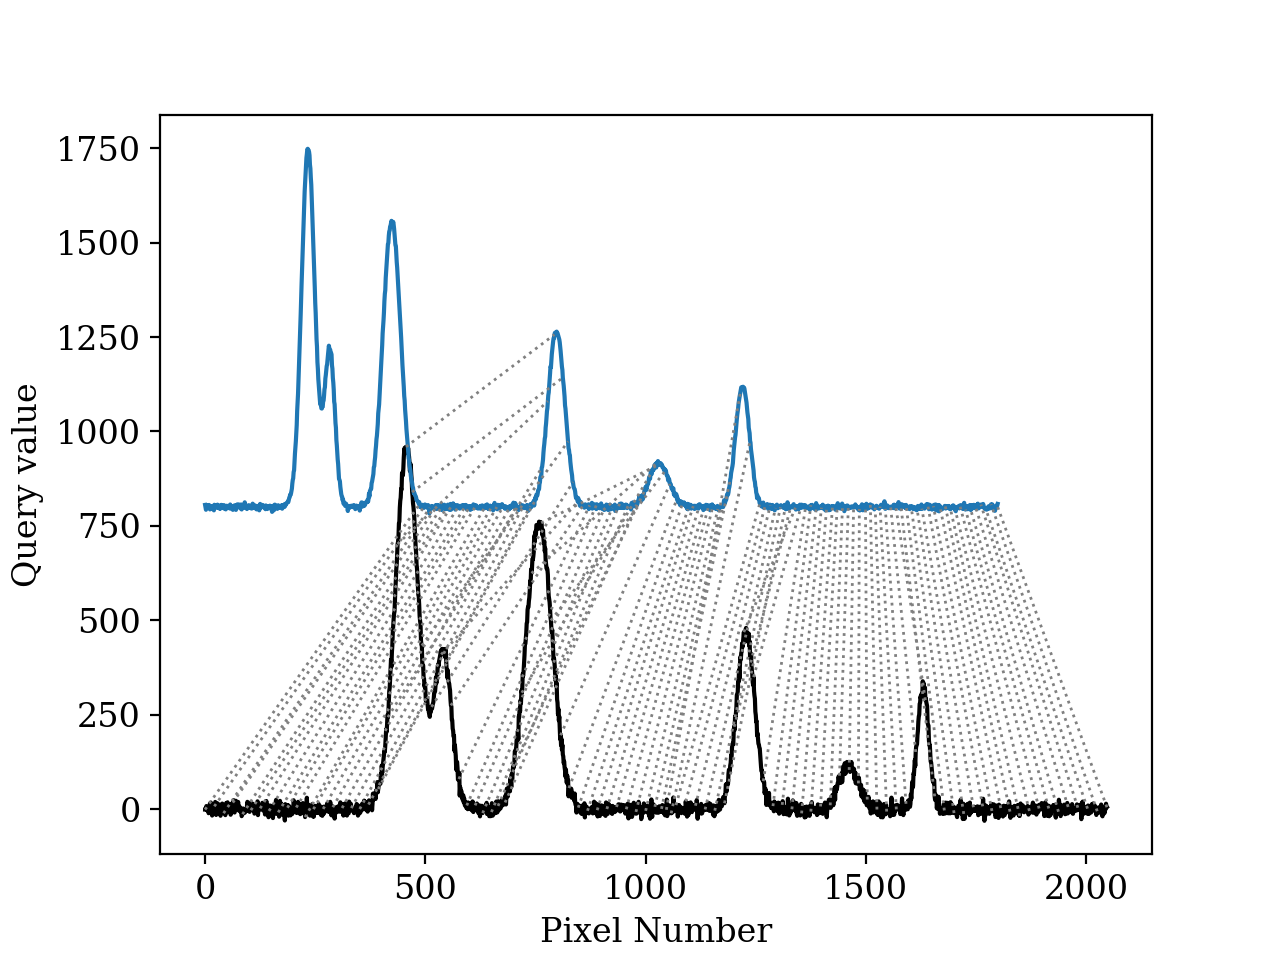

In [3]:
# generate some fake arc lamp spectra 

wav = np.logspace(np.log10(4500), np.log10(8500), 2048)

pix = np.arange(len(wav))

Nlines = 7
lines = np.random.random(size=Nlines)*4000 + 4500
peaks = np.random.random(size=Nlines) * 1000
widths = np.random.random(size=Nlines)*30+30

flux = np.zeros(2048)
for k in range(Nlines):
    flux = flux + _gaus(wav, peaks[k], 0, lines[k], widths[k])

flux2 = np.interp(np.linspace(4500,8500,2048), wav, flux)

# add some gaussian noise
flux = flux+np.random.normal(loc=0, scale=10, size=2048)
flux2 = flux2+np.random.normal(loc=0, scale=5, size=2048)

# plt.plot(wav, flux)
# plt.plot(np.linspace(4500,8500,2048), flux2)

# Here's the TRUTH you would have on hand, either from observatory or a previous reduction:
wav_ref = np.linspace(4500,8500,1800)
flux_ref = np.interp(wav_ref, wav, flux2)   # down-sample the library spectrum


# do the actual DTW matching... there's many settings you can explore...

# the "symmetric1" pattern is smoother, favoring "sloped" steps
alignment = dtw.dtw(flux/np.nanmedian(flux), 
                    flux_ref/np.nanmedian(flux_ref), keep_internals=True,
                    step_pattern='asymmetricP1',
                    open_begin=True, open_end=True) # w/ open-ended solutions!

wav_guess = np.zeros_like(pix)
for k in range(len(flux)):
    refOK = np.where((alignment.index1 == k))[0]
    if len(refOK) > 0:
        wav_guess[k] = np.mean(wav_ref[alignment.index2[refOK]])

# plt.figure()
# plt.plot(pix,wav_guess)
# plt.xlabel('Pixel')
# plt.ylabel('Wavelength ($\AA$)')
# plt.savefig('figures/dtw_cartoon_soln.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

# plt.figure()
# plt.plot(wav_ref, flux_ref, label='Reference')
# plt.plot(wav_guess, flux, label='Solved', alpha=0.75, lw=2)
# plt.legend()


# plt.figure()
dtw.dtwPlotTwoWay(alignment, flux, flux_ref+800, match_indices=100)
plt.xlabel('Pixel Number')
plt.savefig('figures/dtw_cartoon.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

<IPython.core.display.Javascript object>


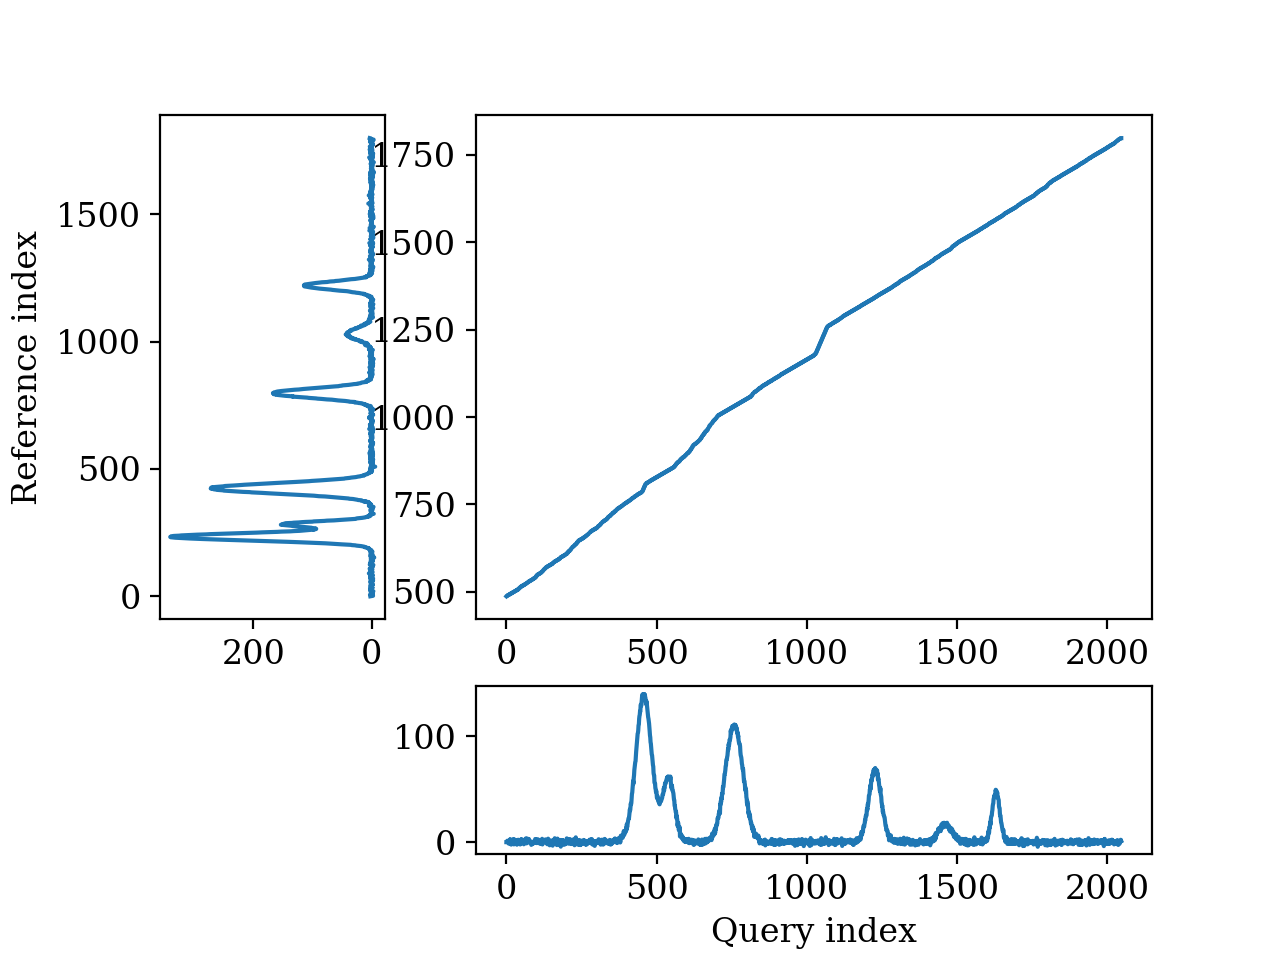

In [4]:
# plt.figure()
alignment.plot(type='threeway',fontsize=12)
plt.savefig('figures/dtw_cartoon_grid.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

# Tough Model

- show the tough model & how it works. 
- This should use pykosmos, including the 2-step mode, GP model, etc

<IPython.core.display.Javascript object>


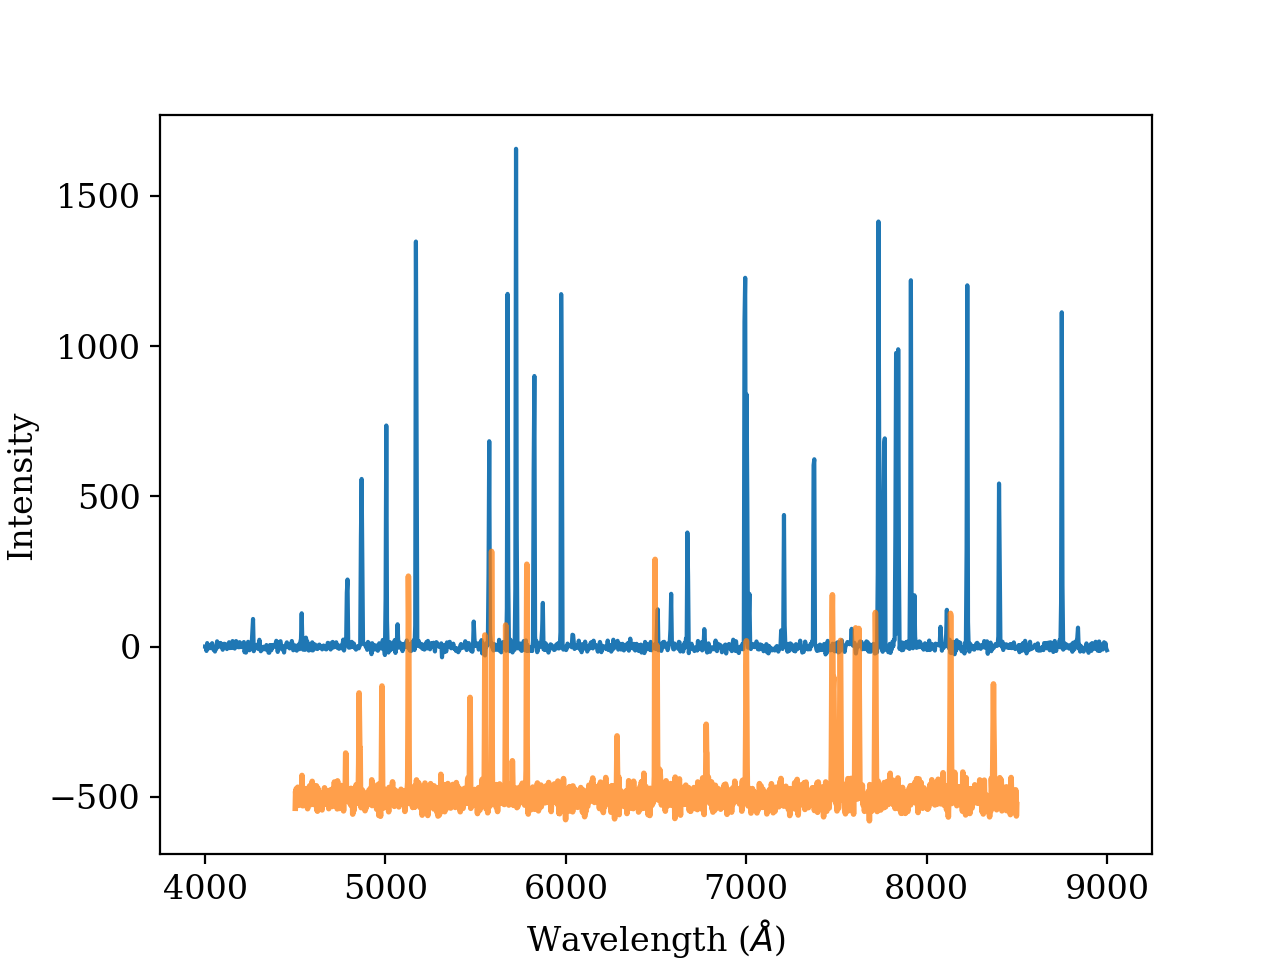

In [7]:
wave_0 = np.linspace(3900,9200,10000)
flux_0 = np.zeros_like(wave_0)

Nlines_0 = 30
lines = np.random.random(size=Nlines_0)*4000 + 4500
peaks = np.random.random(size=Nlines_0) * 1000

for k in range(Nlines_0):
    flux_0 = flux_0 + _gaus(wave_0, peaks[k], 0, lines[k], 2)
    

wave_ref = np.linspace(4000,9000,1280)
flux_ref = np.interp(wave_ref, wave_0, flux_0)

# put some extra small lines into the reference spectrum
elines = 10
for k in range(elines):
    flux_ref = flux_ref + _gaus(wave_ref, np.random.random(size=1)*100, 0, 
                        np.random.random(size=1)*5000+4000, 2)
# put at least 1 major line outside the observed spectrum too
flux_ref = flux_ref + _gaus(wave_ref, 555, 0, 8750, 2)

# add some gaussian noise to the reference
flux_ref = (flux_ref*2) + np.random.normal(loc=0, scale=10, size=flux_ref.size)


# now generate the lower S/N and stretched observations
# this is the perfect wavelength sampling we are trying to recreate!
wave_obs = np.append(np.logspace(np.log10(4500), np.log10(7000), 1024), 
                     np.linspace(7001, 8500, 1024))
pix_obs = np.arange(wave_obs.size)
flux_obs = np.interp(wave_obs, wave_0, flux_0)

# add some gaussian noise to the observation
flux_obs = flux_obs + np.random.normal(loc=0, scale=25, size=flux_obs.size)

# put into Spectrum object
ref = Spectrum1D(spectral_axis=wave_ref*u.AA, flux=flux_ref*u.adu/u.s)
arc = Spectrum1D(spectral_axis=pix_obs*u.pixel, flux=flux_obs*u.adu/u.s)

plt.figure()
plt.plot(wave_ref, flux_ref)
plt.plot(np.linspace(4500,8500,2048), flux_obs-500, lw=2, alpha=0.75, label='Observed')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Intensity')
plt.savefig('figures/dtw_model_before.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

<IPython.core.display.Javascript object>


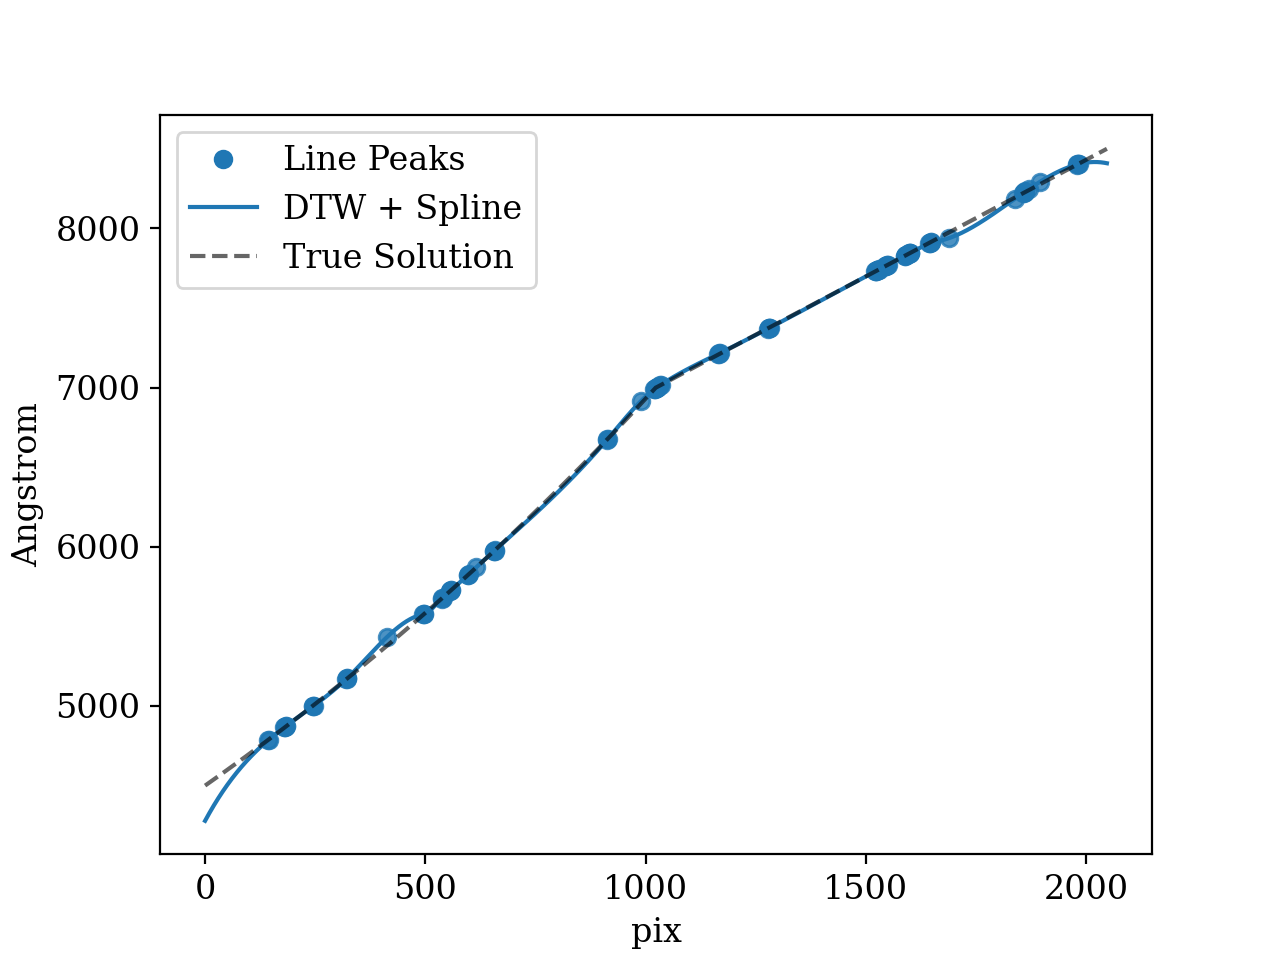

In [8]:
# this is a slightly more difficult use case, where it has to match the pattern AND the end points
# but if there's lots of info (many lines/features), it should be doable!

# xpts,wpts are the peaks (circles)
plt.figure()
xpts,wpts = pk.identify_dtw(arc, ref, upsample=True, display=True, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=True, pthreshold=0.95)

plt.plot([],marker='o',linestyle='none', label='Line Peaks', c='C0')
plt.plot([], c='C0', label='DTW + Spline')

plt.plot(wave_obs, c='k', linestyle='--',label='True Solution', alpha=0.6)
plt.legend()
plt.savefig('figures/dtw_model_fit.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

In [8]:
# ww, we = pk.fit_wavelength(arc, xpts, wpts, display=True, 
#                                mode='gp', returnvar=True, GPRscale=100)
# ww = pk.fit_wavelength(arc, xpts, wpts, display=True, 
#                                mode='spline')

<IPython.core.display.Javascript object>


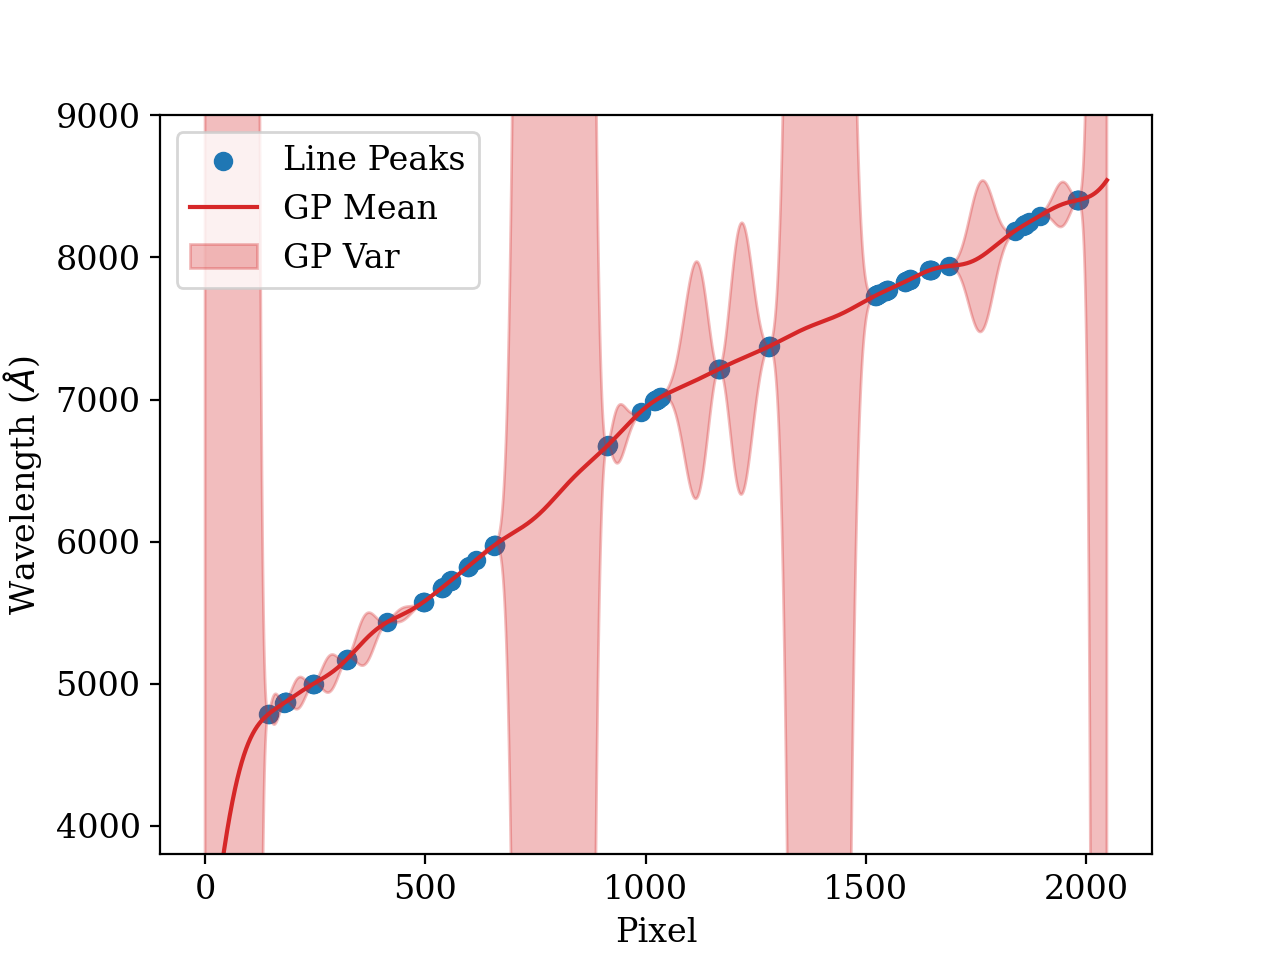

In [9]:
ww, we = pk.fit_wavelength(arc, xpts, wpts, display=False, 
                               mode='gp', returnvar=True)

plt.figure()
plt.scatter(xpts,wpts, label='Line Peaks')
plt.plot(np.arange(len(ww.wavelength.value)), ww.wavelength, c='C3',label='GP Mean')
plt.fill_between(np.arange(len(ww.wavelength.value)), 
                 ww.wavelength.value+we*25, ww.wavelength.value-we*25, 
                 color='C3', alpha=.3,label='GP Var')
plt.legend()
plt.ylim(3800,9000)
plt.xlabel('Pixel')
plt.ylabel('Wavelength ($\AA$)')
plt.savefig('figures/dtw_model_gp.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

# KOSMOS
- solve wavelength solution from real data
- do the stack of Neon solutions at all wavelength centers

In [10]:
# files at each grating mode
# Red-Center
# int_neon_bd28_4211.0001.fits
# int_neon_gd71.0004.fits

# Red-High
# int_neon_bd28_4211.0002.fits

# Red-Low
# int_neon_bd28_4211.0003.fits


# Blue-low
# int_neon_bd28_4211.0004.fits
# int_neon_gd71.0001.fits

# Blue-Center
# int_neon_gd71.0002.fits

# Blue-High
# int_neon_gd71.0003.fits

lbl = ['Blue-Low', 'Blue-Center', 'Blue-High', 'Red-Low','Red-Center','Red-High']

files = ['int_neon_gd71.0001.fits', 'int_neon_gd71.0002.fits', 'int_neon_gd71.0003.fits', 
         'int_neon_bd28_4211.0003.fits', 'int_neon_gd71.0004.fits',#'int_neon_bd28_4211.0001.fits', 
         'int_neon_bd28_4211.0002.fits']


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


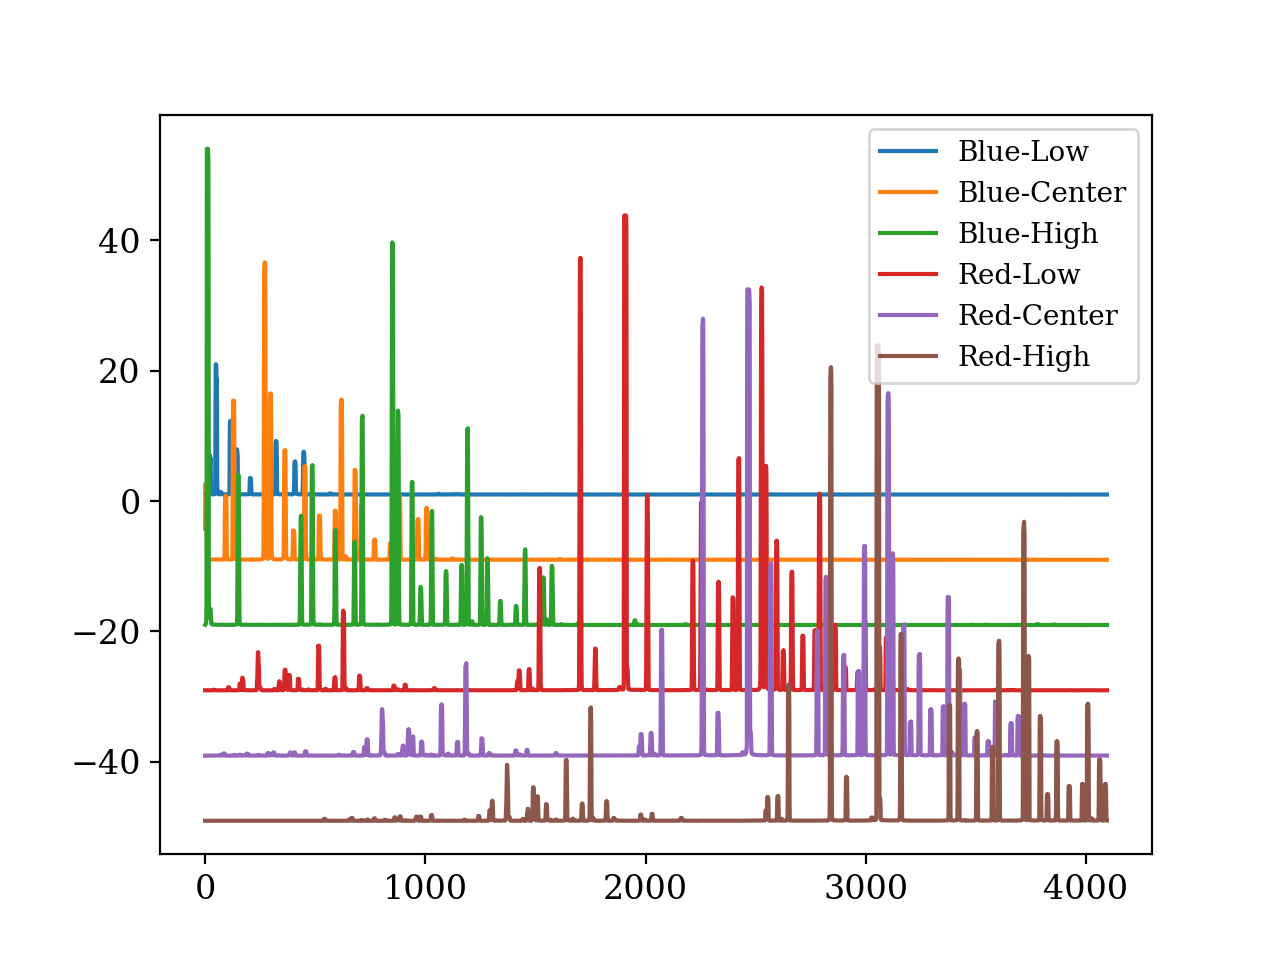

/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


In [11]:
for k in range(len(files)):
    img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
    trace = np.ones(img_k.shape[0]) + 600
    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)

    plt.plot(ex_k.spectral_axis.value, ex_k.flux.value/np.nanmedian(ex_k.flux.value)-k*10, 
             label=lbl[k])
plt.legend(fontsize=10)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


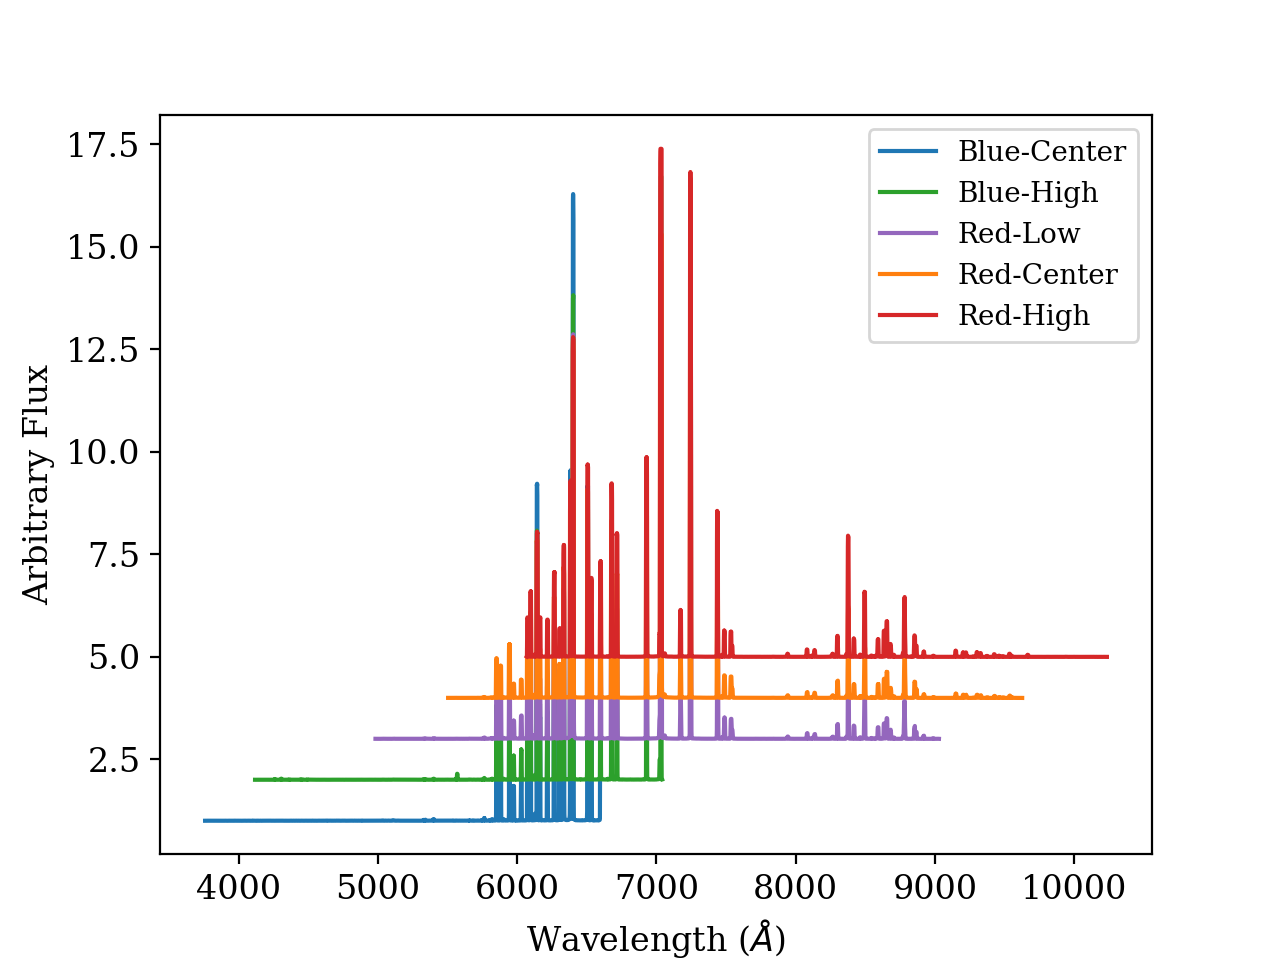

/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


In [12]:
r_temp = pd.read_csv('data/red_center_Neon_gp.spec')
b_temp = pd.read_csv('data/blue_center_Neon_gp.spec')
clrs = ['C0','C0','C2','C4','C1','C3','C5']

###################
templt = Spectrum1D(spectral_axis=b_temp['wave'].values * u.angstrom, 
                    flux=(b_temp['flux'].values-np.nanmedian(b_temp['flux']))/np.std(b_temp['flux'])* u.adu)

# k=1
for k in range(1,2):
    img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
    trace = np.ones(img_k.shape[0]) + 600
    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)
    ex_kn = Spectrum1D(spectral_axis=ex_k.spectral_axis, 
                       flux=((ex_k.flux.value-np.nanmedian(ex_k.flux.value))/np.std(ex_k.flux.value))*u.adu)

    xpts,wpts = pk.identify_dtw(ex_kn, templt, upsample=False, display=False, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=True, pthreshold=0.95)

    ww = pk.fit_wavelength(ex_kn, xpts, wpts, display=False, 
                                   mode='spline')
    plt.plot(ww.wavelength, ww.flux.value+k*1, label=lbl[k],c=clrs[k])

###################
templt = Spectrum1D(spectral_axis=r_temp['wave'].values * u.angstrom, 
                    flux=(r_temp['flux'].values-np.nanmedian(r_temp['flux']))/np.std(r_temp['flux'])* u.adu)

for k in range(2,6):
    img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
    trace = np.ones(img_k.shape[0]) + 600
    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)
    ex_kn = Spectrum1D(spectral_axis=ex_k.spectral_axis, 
                       flux=((ex_k.flux.value-np.nanmedian(ex_k.flux.value))/np.std(ex_k.flux.value))*u.adu)

    xpts,wpts = pk.identify_dtw(ex_kn, templt, upsample=False, display=False, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=True, pthreshold=0.95)

    ww = pk.fit_wavelength(ex_kn, xpts, wpts, display=False, 
                                   mode='spline')

    plt.plot(ww.wavelength, ww.flux.value+k*1, label=lbl[k],c=clrs[k])

    
plt.legend(fontsize=10)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Arbitrary Flux')
plt.savefig('figures/neon_dtw.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


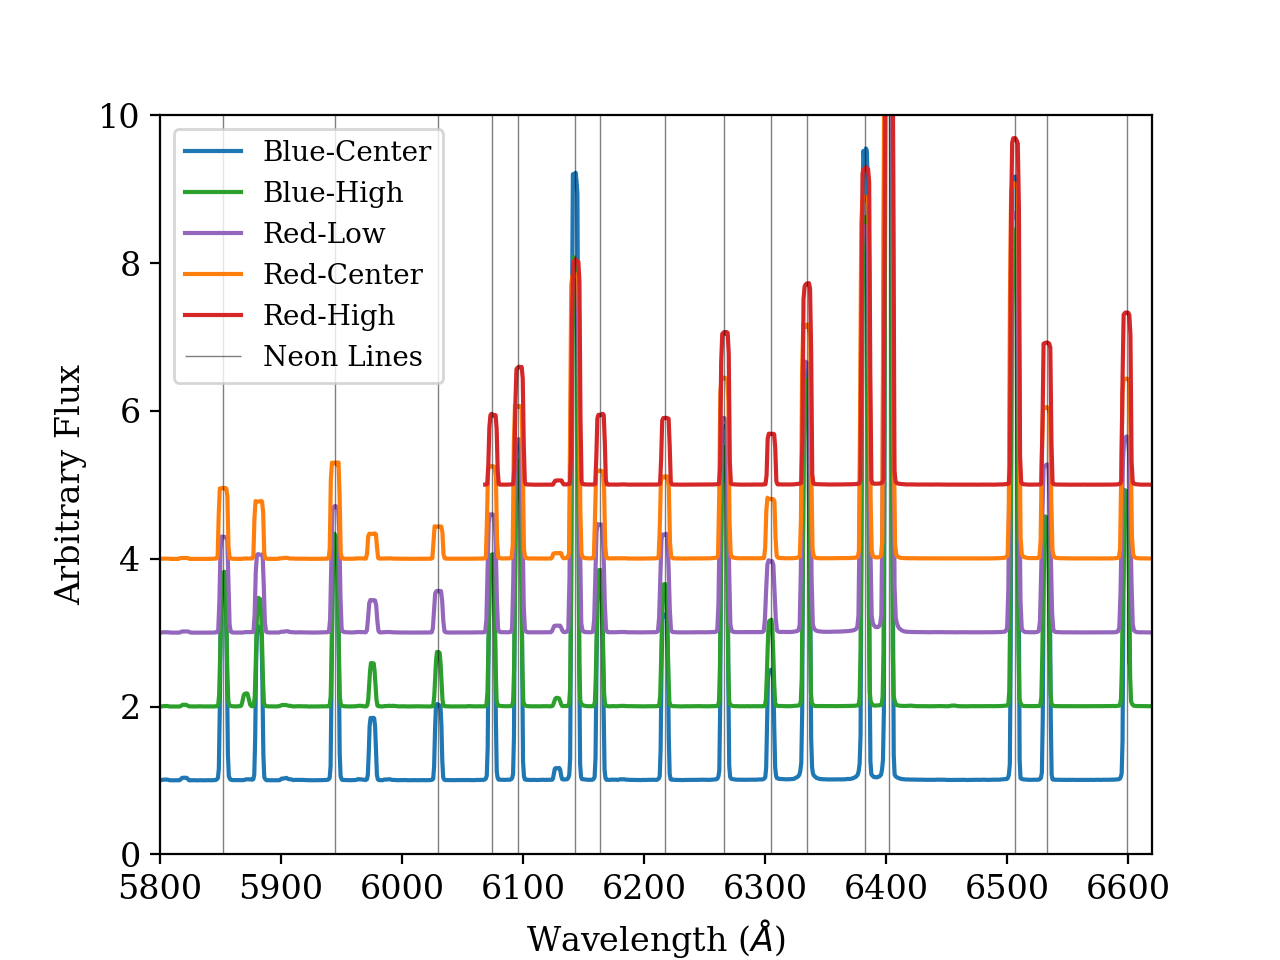

/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:335: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


In [13]:
###################
templt = Spectrum1D(spectral_axis=b_temp['wave'].values * u.angstrom, 
                    flux=(b_temp['flux'].values-np.nanmedian(b_temp['flux']))/np.std(b_temp['flux'])* u.adu)

# k=1
for k in range(1,2):
    img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
    trace = np.ones(img_k.shape[0]) + 600
    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)
    ex_kn = Spectrum1D(spectral_axis=ex_k.spectral_axis, 
                       flux=((ex_k.flux.value-np.nanmedian(ex_k.flux.value))/np.std(ex_k.flux.value))*u.adu)

    xpts,wpts = pk.identify_dtw(ex_kn, templt, upsample=False, display=False, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=True, pthreshold=0.95)

    ww = pk.fit_wavelength(ex_kn, xpts, wpts, display=False, 
                                   mode='spline')
    plt.plot(ww.wavelength, ww.flux.value+k*1, label=lbl[k],c=clrs[k])

###################
templt = Spectrum1D(spectral_axis=r_temp['wave'].values * u.angstrom, 
                    flux=(r_temp['flux'].values-np.nanmedian(r_temp['flux']))/np.std(r_temp['flux'])* u.adu)

for k in range(2,6):
    img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
    trace = np.ones(img_k.shape[0]) + 600
    ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)
    ex_kn = Spectrum1D(spectral_axis=ex_k.spectral_axis, 
                       flux=((ex_k.flux.value-np.nanmedian(ex_k.flux.value))/np.std(ex_k.flux.value))*u.adu)

    xpts,wpts = pk.identify_dtw(ex_kn, templt, upsample=False, display=False, 
                       step_pattern='asymmetric', open_begin=True, open_end=True, 
                       peak_spline=True, pthreshold=0.95)

    ww = pk.fit_wavelength(ex_kn, xpts, wpts, display=False, 
                                   mode='spline')

    plt.plot(ww.wavelength, ww.flux.value+k*1, label=lbl[k],c=clrs[k])

    
idhenear_file = '/Users/james/Dropbox/research_projects/kosmos/kosmos/resources/linelists/idhenearT.dat'
idhenear = pd.read_table(idhenear_file, delimiter='\t', names=('wave', 'line'), comment='#')
plt.vlines(idhenear['wave'][idhenear['line'].str.contains('Ne')], -1, 19, 
           color='k', lw=0.5, alpha=.5, label='Neon Lines')

plt.legend(fontsize=10)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Arbitrary Flux')
plt.xlim(5800,6620)
plt.ylim(0,10)
plt.savefig('figures/neon_dtw2.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


so its not doing AMAZING... a few issues i can imagine:
- the template is not properly wavelength calibrated (very possible), 
    - so we're just matching bad inputs with bad outputs
    - this is **def. happening**, since line library check looks poor
- the lines are flat-topped (saturated?) so gaus fits are poor
- not doing a 2nd pass very well...


## oh well!

pass1


<IPython.core.display.Javascript object>


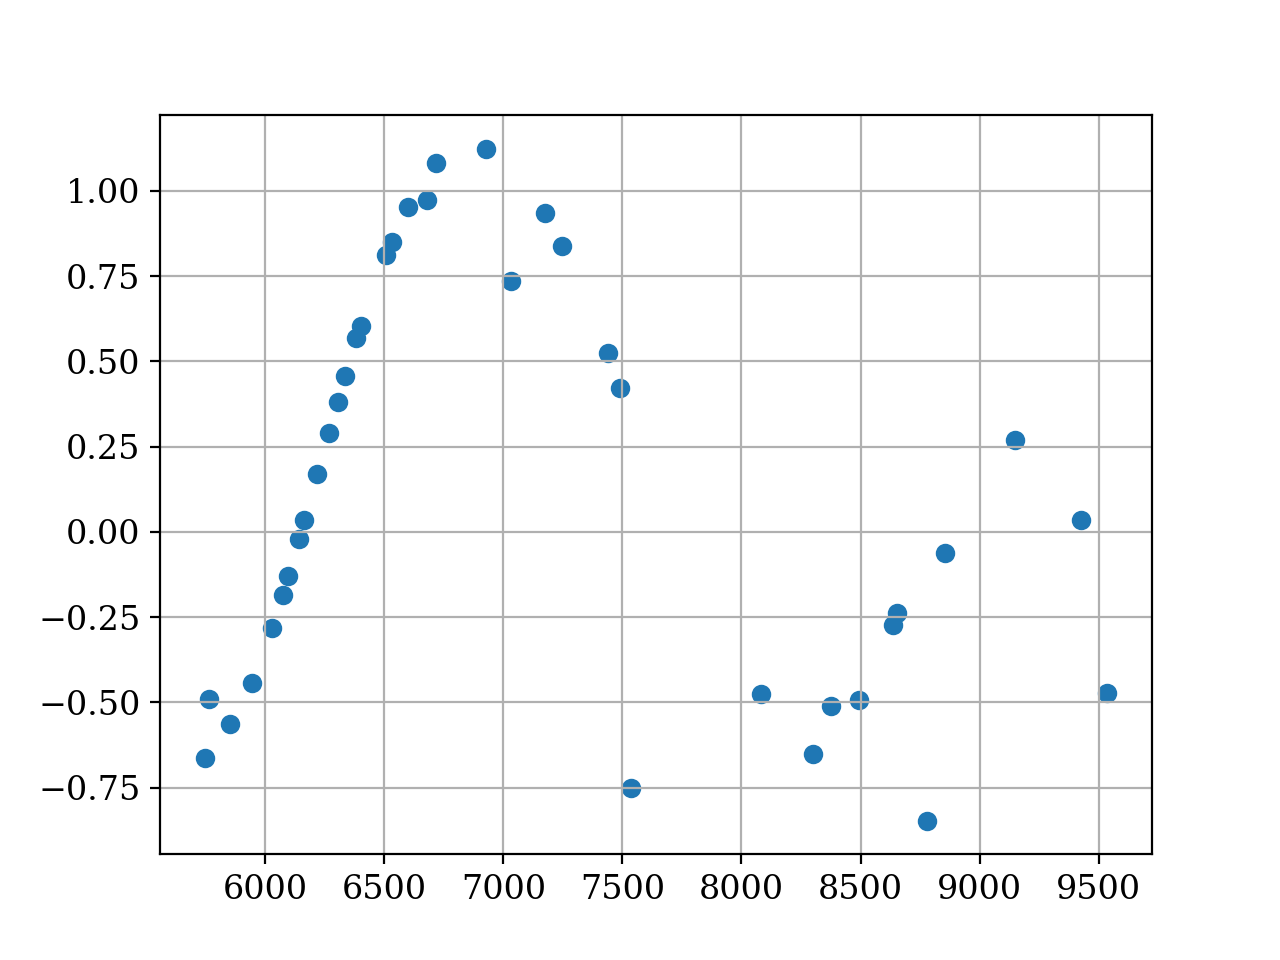

In [185]:
# lets explore residuals from the line library

###################
templt = Spectrum1D(spectral_axis=r_temp['wave'].values * u.angstrom, 
                    flux=(r_temp['flux'].values-np.nanmedian(r_temp['flux']))/np.std(r_temp['flux'])* u.adu)

k=4
img_k = pk.proc('data/'+files[k], bias=None, trim=False, Waxis=0)
trace = np.ones(img_k.shape[0]) + 600
ex_k, _ = pk.BoxcarExtract(img_k, trace, apwidth=3, Waxis=0)
ex_kn = Spectrum1D(spectral_axis=ex_k.spectral_axis, 
                   flux=((ex_k.flux.value-np.nanmedian(ex_k.flux.value))/np.std(ex_k.flux.value))*u.adu)

xpts,wpts = pk.identify_dtw(ex_kn, templt, upsample=False, display=False, 
                   step_pattern='asymmetric', open_begin=True, open_end=True, 
                   peak_spline=True, pthreshold=0.9)

ww = pk.fit_wavelength(ex_kn, xpts, wpts, display=False, mode='poly',deg=11)

Nelines = idhenear['wave'][idhenear['line'].str.contains('Ne')].values
wpts2 = np.array([], dtype=float)
xpts2 = np.array([], dtype=float)

xarr = np.arange(len(ww.wavelength.value))
for k in range(len(Nelines)):
    
    nok = np.where((ww.wavelength.value >= (Nelines[k] - 10)) & 
                   (ww.wavelength.value <= (Nelines[k] + 10)))[0]
    if (len(nok) > 2):
        p0=(np.nanmax(ww.flux.value[nok]),0., Nelines[k], 2.)
        try:
            popt,pcov = curve_fit(_gaus, ww.wavelength.value[nok], ww.flux.value[nok], 
                              p0=p0)
            if np.abs(Nelines[k] - popt[2]) < 5: # throw out bad line fits
                wpts2 = np.append(wpts2, popt[2])
                srt = np.argsort(ww.wavelength.value)
                xfit = np.interp(Nelines[k], ww.wavelength.value[srt], xarr[srt])
                xpts2 = np.append(xpts2, xfit)
        except:
            print(k)

print('pass1')
ex_kn2 = Spectrum1D(spectral_axis=xarr * u.pixel, flux=ww.flux)

ww2 = pk.fit_wavelength(ex_kn, xpts2, wpts2 * u.angstrom, 
                            display=False, mode='poly',deg=6)

lines = np.array([], dtype=float)
resid = np.array([], dtype=float)

for k in range(len(Nelines)):
    
    nok = np.where((ww2.wavelength.value >= (Nelines[k] - 10)) & 
                   (ww2.wavelength.value <= (Nelines[k] + 10)))[0]
    if (len(nok) > 2):
        p0=(np.nanmax(ww2.flux.value[nok]),0., Nelines[k], 2.)
        try:
            popt,pcov = curve_fit(_gaus, ww2.wavelength.value[nok], ww2.flux.value[nok], 
                              p0=p0)
            if np.abs(Nelines[k] - popt[2]) < 2:
                lines = np.append(lines, Nelines[k])
                resid = np.append(resid, Nelines[k] - popt[2])
            
        except:
            print(k)
            
plt.figure()        
plt.scatter(lines,resid)
plt.grid(True)